# Niveaux du Lac Léman

Avec la mission Copernic il est possible de récupérer des données sur le niveau des grands lacs et des rivières.

Dans cet exercice nous allons nous intéresser au lac Léman qui n'est pas trop loin de chez nous.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2. Accès au fichier de données.

_(Remplacer le nom du répertoire de données si nécessaire.)_

In [9]:
# # Changer le nom du répertoire de données si nécessaire.
# datadir = '/content/drive/MyDrive/data/lakes'
# files = os.listdir(datadir)
# filename = os.path.join(datadir,files[0])
# print(filename)

## 3. Chargement du fichier JSON
On crée une table contenant juste la date (index), le niveau et la précision.

Finalement on affiche la courbe avec un tube de confiance correspondant à la précision de la mesure.

In [2]:
filename="data.json"
with open(filename) as jdf:
    jd = json.load(jdf)

In [3]:
jd['geometry']

{'type': 'Point', 'coordinates': [6.54, 46.36]}

In [4]:
df = pd.DataFrame(jd['data'])
df.set_index(pd.to_datetime(df['datetime']), inplace=True)
df.drop(columns=['datetime', 'identifier', 'time'], inplace=True)
df.columns = ['Height', 'Precision']
df

,Height,Precision
datetime,,
2016-06-14 10:10:00,371.78,0.09
2016-07-11 10:10:00,371.64,0.11
2016-08-07 10:10:00,371.71,0.09
2016-09-03 10:10:00,371.63,0.07
2016-09-30 10:10:00,371.62,0.11
...,...,...
2022-11-19 10:10:00,371.63,0.03
2022-12-12 20:58:00,371.57,0.03
2022-12-16 10:10:00,371.59,0.06


In [5]:
# Simplifiez vous le travail en extrayant les variables.
y = df['Height'] # L'altitude
e = df['Precision'] # La précision

In [6]:
df.info()
df.index.dtype

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141 entries, 2016-06-14 10:10:00 to 2023-01-12 10:10:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Height     141 non-null    float64
 1   Precision  141 non-null    float64
dtypes: float64(2)
memory usage: 3.3 KB


dtype('<M8[ns]')

Text(0, 0.5, 'm')

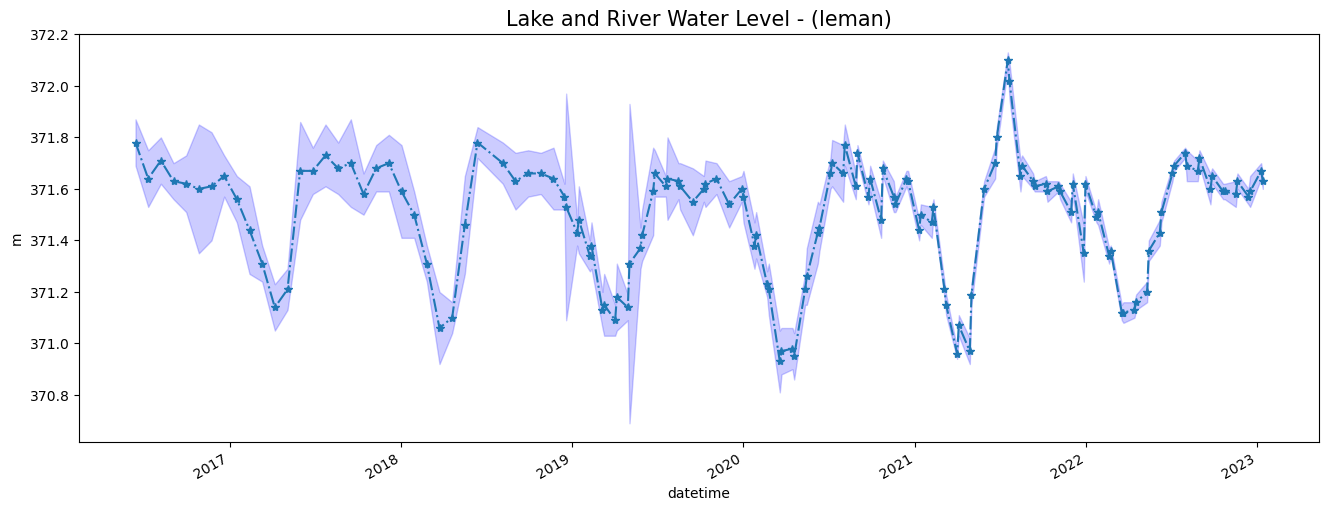

In [7]:
# Affichage de la courbe.
fig,ax = plt.subplots(figsize= (16, 6))
x = df.index
y.plot(style='*-.')
ax.fill_between(x, y-e, y+e, color='b', alpha=0.2)
plt.title(jd['properties']['long_name']+' - ('+jd['properties']['lake']+')', fontsize=15)
plt.ylabel('m')

# 4. Etude de la tendance.

On enlève la saisonnalité correspondant aux variations annuelles.
Montrez qu'il n'est pas forcément nécessaire d'aller au delà des saisons.

Existe-t-il une tendance ?

In [49]:
import statsmodels.api as sm
from statsmodels.tsa.deterministic import CalendarFourier

In [50]:
# Création d'un signal multivarié d'harmoniques de l'année.
fourier_gen = CalendarFourier('Y', order=3)
fg = fourier_gen.in_sample(df.index)
fg.columns

Index(['sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)'],
      dtype='object')

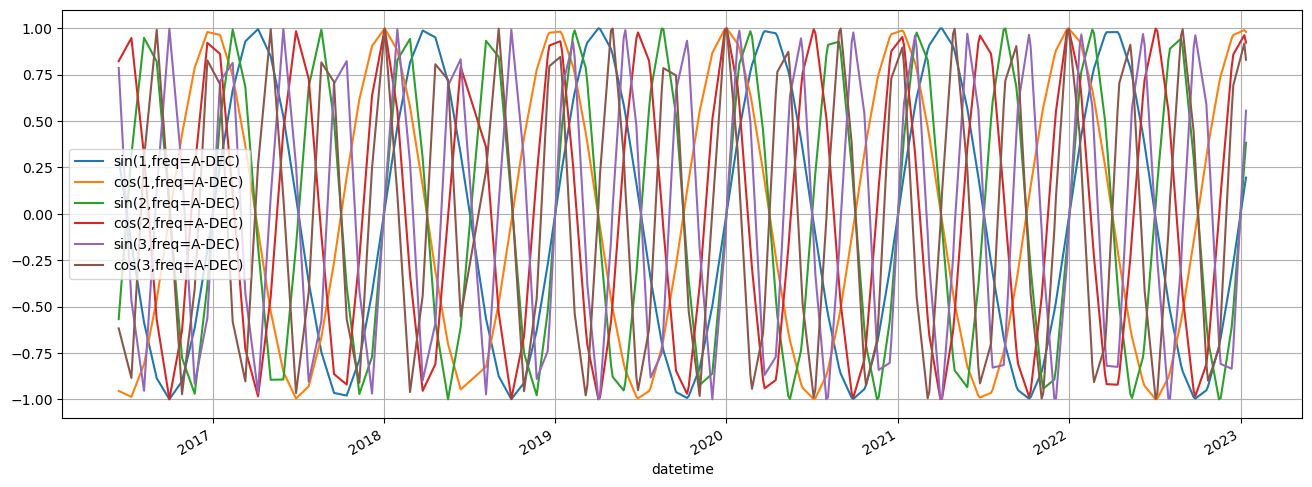

In [51]:
fg.plot(figsize=(16, 6))
plt.grid()

In [52]:
# Rajouter la constante et la tendance.
fg['constant']= 1
fg['days'] = (fg.index - fg.index[0]).total_seconds()/(24*3600)

In [53]:
# Regression linéaire de y sur les harmoniques, la constante et la tendance.
mod = sm.OLS(y, fg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Height   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     121.8
Date:                Sun, 26 Mar 2023   Prob (F-statistic):           1.18e-54
Time:                        17:00:37   Log-Likelihood:                 150.93
No. Observations:                 141   AIC:                            -285.9
Df Residuals:                     133   BIC:                            -262.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
sin(1,freq=A-DEC)    -0.2475      0.01

## 5. Un cas particulier.

Montrez que l'été 2021 a été inhabituel.

In [54]:
r = pd.Series(res.predict(),index=df.index)

Text(0, 0.5, 'm')

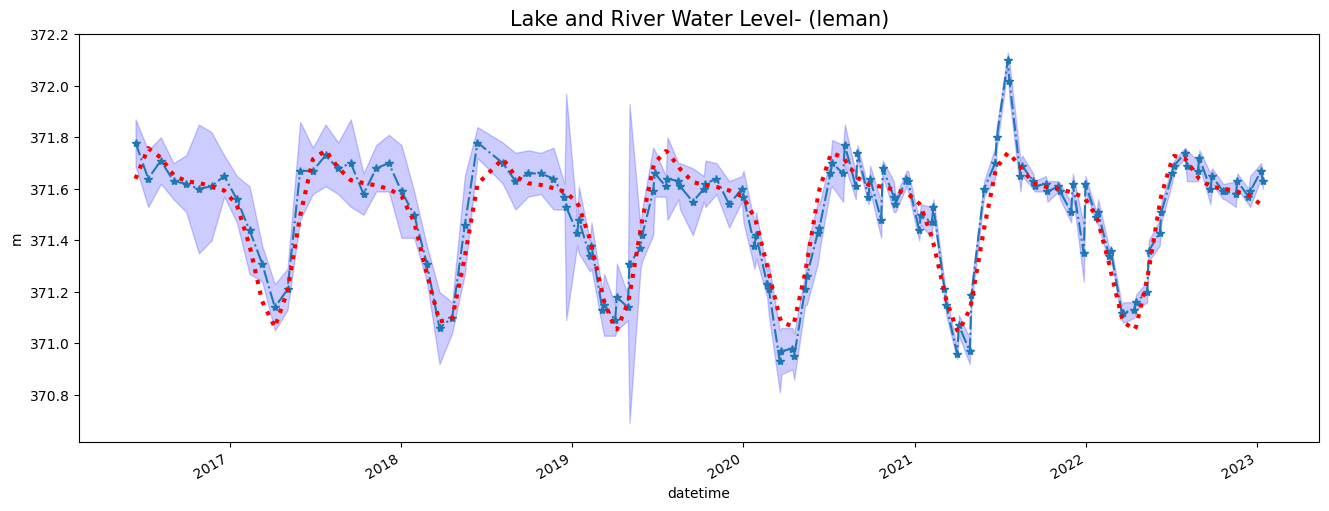

In [62]:
fig,ax = plt.subplots(figsize=(16, 6))
y.plot(style='*-.')
ax.fill_between(x, y-e, y+e, color='b', alpha=0.2)
r.plot(style=':', color='r', linewidth=3)
plt.title(jd['properties']['long_name']+ '- ('+jd['properties']['lake']+')', fontsize=15)
plt.ylabel('m')

Prendre une marge d'erreur de +/- 3 écart-types pour garantir 1%. de précision.

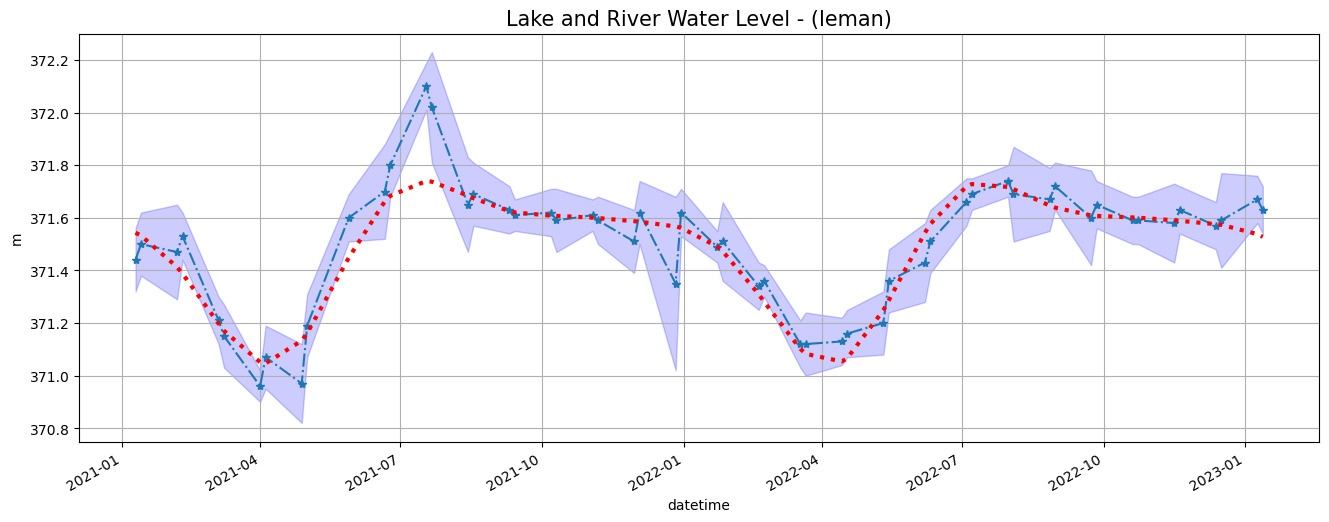

In [63]:
ind = x>'2021'
fig,ax= plt.subplots(figsize=(16, 6))
y[ind].plot(style='*-.')
ax.fill_between(x[ind], y[ind]-3*e[ind], y[ind]+3*e[ind], color='b', alpha=0.2)
r[ind].plot(style=':', color='r', linewidth=3)
plt.title(jd['properties']['long_name'] + ' - ('+jd['properties']['lake']+')', fontsize=15)
plt.ylabel('m')
plt.grid()

## 6. Prise en compte de la dépendance temporelle.

In [64]:
from statsmodels.tsa.ar_model import AutoReg

Afficher les résidus.

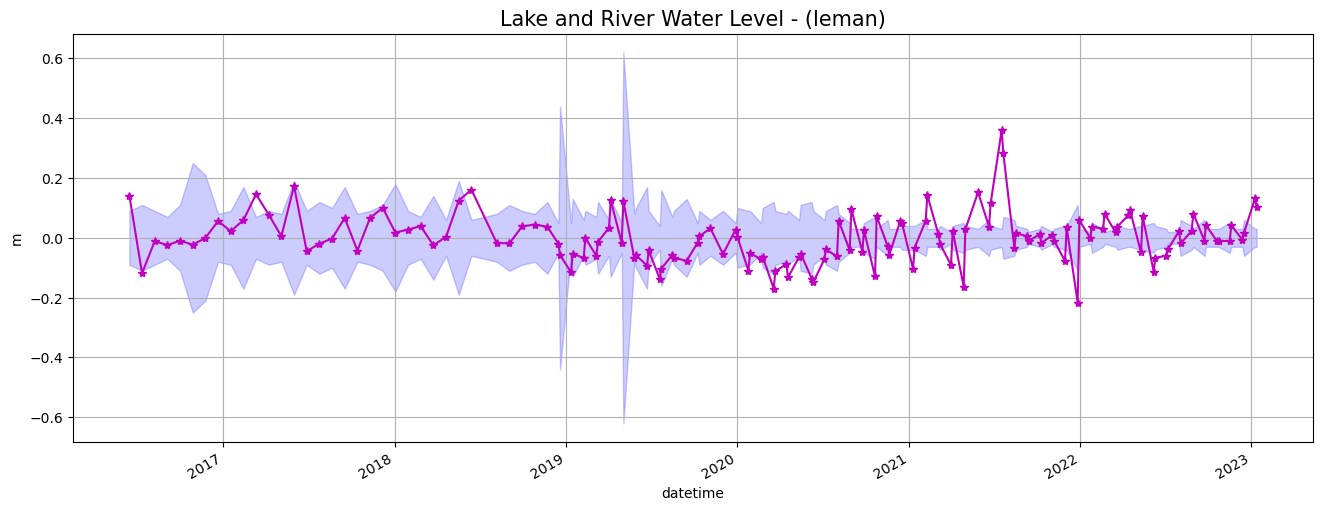

In [68]:
z = y-r
fig,ax= plt.subplots(figsize=(16, 6))
z.plot(style='*-', color='m')
ax.fill_between(x, -e, +e, color='b', alpha=0.2)
plt.title(jd['properties']['long_name'] + ' - ('+jd['properties']['lake']+')', fontsize=15)
plt.ylabel('m')
plt.grid();

Construire un modèle autorégressif sur les résidus. (On négligera la date et on supposera que les mesures arrivent régulièrement.)

In [69]:
lags = [1, 2]
ar = AutoReg(z.values, lags=lags, trend='n').fit()
print(ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  141
Model:                     AutoReg(2)   Log Likelihood                 162.669
Method:               Conditional MLE   S.D. of innovations              0.075
Date:                Sun, 26 Mar 2023   AIC                           -319.337
Time:                        17:06:54   BIC                           -310.534
Sample:                             2   HQIC                          -315.760
                                  141                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.2948      0.082      3.599      0.000       0.134       0.455
y.L2           0.1955      0.082      2.389      0.017       0.035       0.356
                                    Roots           

Rajouter les résultats de prédiction et afficher de nouveau les courbes.

In [70]:
len(y), len(ar.predict())

(141, 141)

In [ ]:
r1 = r.copy()
r1[max(lags):] += ar.predict()

In [ ]:
fig,ax = plt.subplots(figsize = (16,6))
...